# compare runs with no tACS, with tACS, with tACS + SASS

In [15]:
import numpy as np
import pyxdf
import matplotlib.pyplot as plt
from scipy import signal, fftpack
from scipy.signal import hilbert, butter, filtfilt

import mne 
from mne.time_frequency import psd_welch

In [16]:
## import no-tacs data R1

subj = "P04"
run = "R1"

data, header=  pyxdf.load_xdf('../recordings/02_06/'+subj+'-no-tacs-'+run+'.xdf')

if data[0]['info']['name'][0] == 'ExperimentMarkers': 
    markers_data = data[0] 
    opm_data = data[1]
else: 
    markers_data = data[1]   
    opm_data = data[0]

fs = 1000 # sampling rate 

opm_time_stamps = opm_data['time_stamps'] 

## get the start and end marker experiment 

## set up the markers information
marker_id_start = 7
marker_id_end = 9
marker_id_trial_end = 2
marker_id_trial_start = 1

markers_data_ts = markers_data['time_stamps']

# get the approximate index in chassis time stamp for start trigger
start_marker = markers_data_ts[np.where(markers_data['time_series'].flatten() == marker_id_start)[0]][0]
diff = start_marker - opm_time_stamps 
diff_bool = (diff < 0.001) & (diff > 0) 
start_marker_index_no_tacs = np.where(opm_time_stamps == opm_time_stamps[diff_bool])[0][0] 

# get the approximate index in chassis time stamp for end trigger
end_marker = markers_data_ts[np.where(markers_data['time_series'].flatten() == marker_id_end)[0]][0]
diff = end_marker - opm_time_stamps 
diff_bool = (diff < 0.001) & (diff > 0) 
end_marker_index_no_tacs = np.where(opm_time_stamps == opm_time_stamps[diff_bool])[0][0]
num_trials = int((markers_data['time_series'].flatten().shape[0] - 2)/ 2) # divide by two because of start and end markers 


#make epochs time stamps in chassis time
markers_data_cut = markers_data['time_series'].flatten()[1:-1] # remove start and end marker timestamps
markers_data_ts = markers_data_ts[1:-1] #remove start and end marker



## setting up the raw time series data for processing 

adc_diode_idx = 11
# adc_tacs_idx = 0
## There will be _full and _cut, the difference is in the duration cut.
opm_data_full = opm_data['time_series'][:] * 1e-15 #in tesla

num_channels_w_adcs = opm_data['time_series'][:].shape[1]
num_samples = opm_data_full.shape[0]

# channel names according to the order of the OPM data without the ADCs
channel_names = np.zeros(shape=[num_channels_w_adcs], dtype='object') 
channel_types = np.zeros(shape=[num_channels_w_adcs], dtype='object')
channel_units = np.zeros(shape=[num_channels_w_adcs], dtype='object')
for i, channel in enumerate(opm_data['info']['desc'][0]['channels'][0]['channel']):
    # print(channel)
    channel_names[i] = channel['label'][0]
    channel_types[i] = channel['type'][0]
    channel_units[i] = channel['unit'][0]

## channels ordering
ref_channels = ['01:01:50', '01:02:50', '01:05:50']

tACS_channel = ['00:00:0']
photodiode_channel = ['01:00:0']

channel_orders = ['00:12:50','00:08:50', '01:04:50'
, '00:11:50', '00:07:50', '01:03:50'
, '00:10:50', '00:06:50', '00:03:50'
, '00:09:50', '00:05:50', '00:01:50']


#make mne object, maybe for easier filtering or other pre-processing stuff..
info = mne.create_info(list(channel_names), fs, list(channel_types))
raw_no_tacs = mne.io.RawArray(opm_data_full[:].T, info)
raw_no_tacs.drop_channels(ref_channels)
#get the tACS and photodiode mne raw data
raw_tacs = raw_no_tacs.copy().pick_channels(tACS_channel)
raw_photodiode_no_tacs = raw_no_tacs.copy().pick_channels(photodiode_channel)
# raw will only be left with primary channels only
raw_no_tacs.drop_channels(tACS_channel)
raw_no_tacs.drop_channels(photodiode_channel)

raw_no_tacs.reorder_channels(channel_orders)

raw_fil_10_no_tacs = raw_no_tacs.copy().filter(9,11)
raw_fil_1_30_no_tacs = raw_no_tacs.copy().filter(1,30)

raw_arr_f10 = raw_fil_10_no_tacs[:][0]
num_primary_channels = raw_arr_f10.shape[0]




Creating RawArray with float64 data, n_channels=17, n_times=73509
    Range : 0 ... 73508 =      0.000 ...    73.508 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge: 11.00 Hz
- Upper transition bandwidth: 2.75 Hz (-6 dB cutoff frequency: 12.38 Hz)
- Filter length: 1467 samples (1.467 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband atten

In [17]:
## import tacs data R1

data, header=  pyxdf.load_xdf('../recordings/02_06/'+subj+'-tacs-'+run+'.xdf')

if data[0]['info']['name'][0] == 'ExperimentMarkers': 
    markers_data = data[0] 
    opm_data = data[1]
else: 
    markers_data = data[1]   
    opm_data = data[0]

opm_time_stamps = opm_data['time_stamps'] 


## set up the markers information
marker_id_start = 7
marker_id_end = 9
marker_id_trial_end = 2
marker_id_trial_start = 1

markers_data_ts = markers_data['time_stamps']

# get the approximate index in chassis time stamp for start trigger
start_marker = markers_data_ts[np.where(markers_data['time_series'].flatten() == marker_id_start)[0]][0]
diff = start_marker - opm_time_stamps 
diff_bool = (diff < 0.001) & (diff > 0) 
start_marker_index_tacs = np.where(opm_time_stamps == opm_time_stamps[diff_bool])[0][0] 

# get the approximate index in chassis time stamp for end trigger
end_marker = markers_data_ts[np.where(markers_data['time_series'].flatten() == marker_id_end)[0]][0]
diff = end_marker - opm_time_stamps 
diff_bool = (diff < 0.001) & (diff > 0) 
end_marker_index_tacs = np.where(opm_time_stamps == opm_time_stamps[diff_bool])[0][0]
num_trials = int((markers_data['time_series'].flatten().shape[0] - 2)/ 2) # divide by two because of start and end markers 


#make epochs time stamps in chassis time
markers_data_cut = markers_data['time_series'].flatten()[1:-1] # remove start and end marker timestamps
markers_data_ts = markers_data_ts[1:-1] #remove start and end marker



## setting up the raw time series data for processing 

adc_diode_idx = 11
# adc_tacs_idx = 0
## There will be _full and _cut, the difference is in the duration cut.
opm_data_full = opm_data['time_series'][:] * 1e-15 #in tesla

num_channels_w_adcs = opm_data['time_series'][:].shape[1]
num_samples = opm_data_full.shape[0]

# channel names according to the order of the OPM data without the ADCs
channel_names = np.zeros(shape=[num_channels_w_adcs], dtype='object') 
channel_types = np.zeros(shape=[num_channels_w_adcs], dtype='object')
channel_units = np.zeros(shape=[num_channels_w_adcs], dtype='object')
for i, channel in enumerate(opm_data['info']['desc'][0]['channels'][0]['channel']):
    # print(channel)
    channel_names[i] = channel['label'][0]
    channel_types[i] = channel['type'][0]
    channel_units[i] = channel['unit'][0]

## channels ordering
ref_channels = ['01:01:50', '01:02:50', '01:05:50']

tACS_channel = ['00:00:0']
photodiode_channel = ['01:00:0']

channel_orders = ['00:12:50','00:08:50', '01:04:50'
, '00:11:50', '00:07:50', '01:03:50'
, '00:10:50', '00:06:50', '00:03:50'
, '00:09:50', '00:05:50', '00:01:50']


#make mne object, maybe for easier filtering or other pre-processing stuff..
info = mne.create_info(list(channel_names), fs, list(channel_types))
raw_tacs = mne.io.RawArray(opm_data_full[:].T, info)
raw_tacs.drop_channels(ref_channels)
#get the tACS and photodiode mne raw data
# raw_tacs_adc = raw.copy().pick_channels(tACS_channel)
raw_photodiode_tacs = raw_tacs.copy().pick_channels(photodiode_channel)
# raw will only be left with primary channels only
raw_tacs.drop_channels(tACS_channel)
raw_tacs.drop_channels(photodiode_channel)

raw_tacs.reorder_channels(channel_orders)

raw_fil_10_tacs = raw_tacs.copy().filter(9,11)
raw_fil_1_30_tacs = raw_tacs.copy().filter(1,30)



Creating RawArray with float64 data, n_channels=17, n_times=90015
    Range : 0 ... 90014 =      0.000 ...    90.014 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge: 11.00 Hz
- Upper transition bandwidth: 2.75 Hz (-6 dB cutoff frequency: 12.38 Hz)
- Filter length: 1467 samples (1.467 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband atten

# SASS

In [18]:
from scipy import linalg


def wrap(phases):
    return (phases + np.pi) % (2 * np.pi) - np.pi

def get_plv(phases):
    plv = (np.exp(1j*phases)).mean()
    return plv

def circ_detrend(phases): 
    # uses Euler's formula to get angle's vector, then get mean angle
    # plv = np.abs(np.sum(complex_phase_diff)/ len(phases))
    # plv= np.abs(np.sum(np.exp(1j*phases))) / len(phases)
    plv = get_plv(phases)
    mean = np.angle(plv)
    return plv, wrap(phases-mean) 
    
def find_n_nulls(A,B,D,M):
    mses = []
    for n_nulls in range(A.shape[0]):
        DI = np.ones(M.shape[0])
        DI[:n_nulls] = 0
        DI = np.diag(DI)
        P = M.dot(DI).dot(D)
        mses.append(np.mean((np.diag(B)-np.diag(P.dot(A).dot(P.T)))**2))
    return np.argmin(mses)

def sass(data,A,B):

    """
    Applies the Stimulation Artifact Source Separation to tACS-EEG data
    Parameters
    ----------
    data : numpy.ndarray
        m x n ndarray : m: number of channels, n: number of samples
        The tACS-EEG data to be processed, bandpass filtered into the frequency band of interest
    A : numpy.ndarray
        m x m ndarray : m: number of channels
        The covariance matrix of EEG calibration data with tACS
    B : numpy.ndarray
        m x m ndarray : m: number of channels
        The covariance matrix of EEG calibration data without tACS
    Returns
    -------
    cleaned_data : numpy.ndarray
        m x n ndarray : m: number of channels, n: number of samples
        The processed tACS-EEG data
    """

    eigen_values, eigen_vectors = linalg.eig(A,B)
    eigen_values = eigen_values.real
    eigen_vectors = eigen_vectors.real
    ix = np.argsort(eigen_values)[::-1]
    D = eigen_vectors[:,ix].T
    M = linalg.pinv2(D)
    n_nulls = find_n_nulls(A,B,D,M)
    print("n components :", n_nulls)
    DI = np.ones(M.shape[0])
    DI[:n_nulls] = 0
    DI = np.diag(DI)
    P = M.dot(DI).dot(D)
    cleaned_data = P.dot(data)
    return cleaned_data

# Get the 10hz signal phase information from tACS 

# raw_tacs_phase = np.angle(raw_tacs.copy().filter(205, 235, picks=tACS_channel).apply_hilbert(envelope=True, picks=tACS_channel).filter(9,11, picks=tACS_channel).apply_hilbert(envelope=False, picks=tACS_channel)._data.squeeze()[start_marker_index:end_marker_index])
# raw_tacs_phase = raw_tacs.copy().filter(205, 235, picks=tACS_channel).apply_hilbert(envelope=True, picks=tACS_channel).filter(9,11, picks=tACS_channel)._data.squeeze()


# raw_f10_sass = raw_fil_10_tacs.copy().filter(205, 235).apply_hilbert(envelope=True).filter(9,11,)._data[:,start_marker_index:end_marker_index]
raw_sass = raw_fil_10_no_tacs.copy()
B = np.cov(raw_fil_10_no_tacs._data)
A = np.cov(raw_fil_10_tacs._data)
raw_sass._data = sass(raw_fil_1_30_tacs._data, A, B)


n components : 5


Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)


Text(0, 0.5, 'Power')

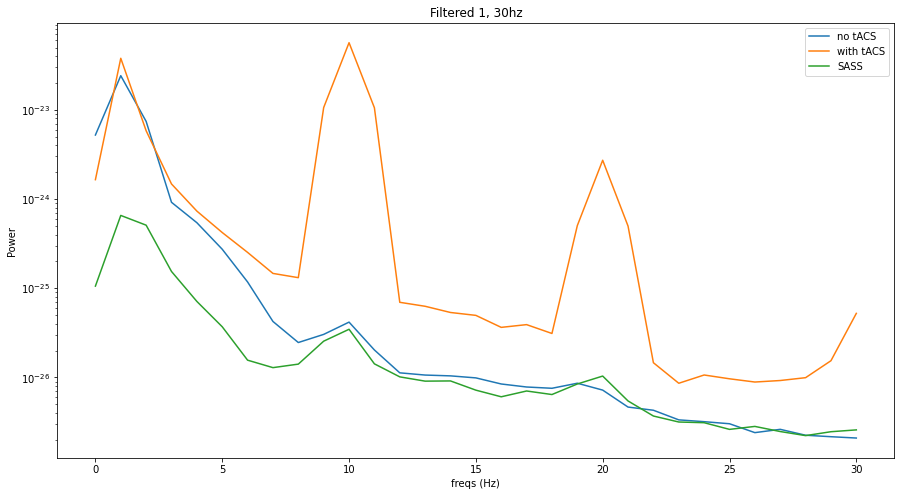

In [19]:
plt.figure(figsize=(15,8))
tmin_no_tacs = start_marker_index_no_tacs/fs
tmax_no_tacs = end_marker_index_no_tacs/fs

tmin_tacs = start_marker_index_tacs/fs
tmax_tacs = end_marker_index_tacs/fs

pxx_no_tacs, f = psd_welch(raw_fil_1_30_no_tacs, fmin=0, fmax=30, n_fft=1000, picks="all", tmin=tmin_no_tacs, tmax=tmax_no_tacs, average="mean")
pxx_tacs, f = psd_welch(raw_fil_1_30_tacs, fmin=0, fmax=30, n_fft=1000, picks="all", tmin=tmin_tacs, tmax=tmax_tacs, average="mean")
pxx_sass, f = psd_welch(raw_sass, fmin=0, fmax=30, n_fft=1000, picks="all", tmin=tmin_tacs, tmax=tmax_tacs, average="mean")


plt.semilogy(f, np.mean(pxx_no_tacs, axis=0),label="no tACS")
plt.semilogy(f, np.mean(pxx_tacs, axis=0), label="with tACS")
plt.semilogy(f, np.mean(pxx_sass, axis=0), label="SASS")

plt.legend()
plt.title("Filtered 1, 30hz")
plt.xlabel("freqs (Hz)")
plt.ylabel("Power")
    

<Figure size 1080x576 with 0 Axes>

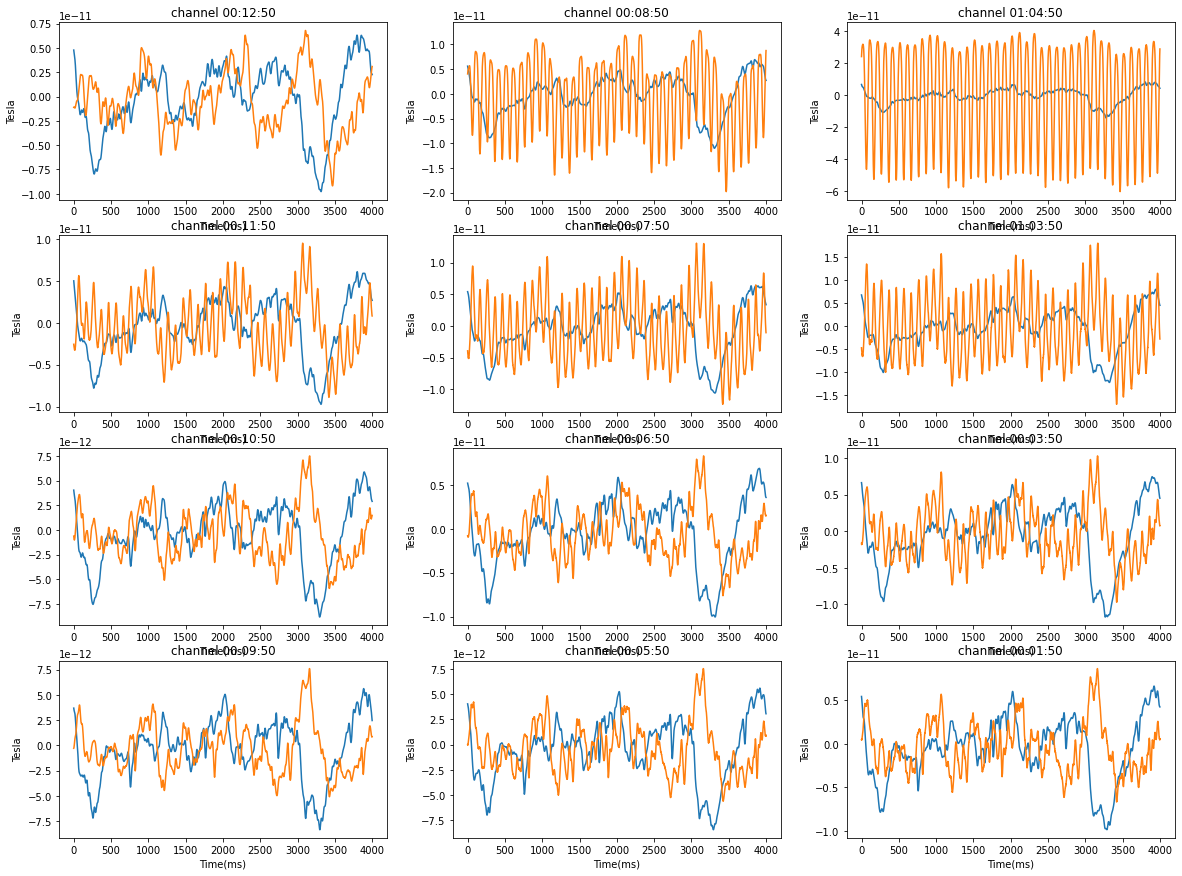

In [20]:
plt.figure(figsize=(15,8))

start_no_tacs = start_marker_index_no_tacs + 2000
end_no_tacs = start_marker_index_no_tacs + 6000

start_tacs = start_marker_index_tacs + 2000
end_tacs = start_marker_index_tacs + 6000

plt.figure(figsize=(20,15))
for i in range(raw_no_tacs._data.shape[0]): 
    plt.subplot(4,3,i+1)
    plt.title('channel ' + raw_no_tacs.ch_names[i])
    # plt.plot(raw_no_tacs._data[i, start_no_tacs:end_no_tacs])
    plt.plot(raw_fil_1_30_no_tacs._data[i, start_no_tacs:end_no_tacs])

    plt.plot(raw_fil_1_30_tacs._data[i, start_tacs:end_tacs])

    # plt.ylim((-8e-9,8e-9))
    plt.ylabel('Tesla')
    plt.xlabel('Time(ms)')

# plt.semilogy(f, np.mean(raw, axis=0),label="no tACS")
# plt.semilogy(f, np.mean(pxx_tacs, axis=0), label="with tACS")
# plt.semilogy(f, np.mean(pxx_sass, axis=0), label="SASS")

# plt.legend()
# plt.title("Filtered 1, 30hz")
# plt.xlabel("freqs (Hz)")
# plt.ylabel("Power")
    

# Let's check the phase differences

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge: 11.00 Hz
- Upper transition bandwidth: 2.75 Hz (-6 dB cutoff frequency: 12.38 Hz)
- Filter length: 1467 samples (1.467 sec)

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) met

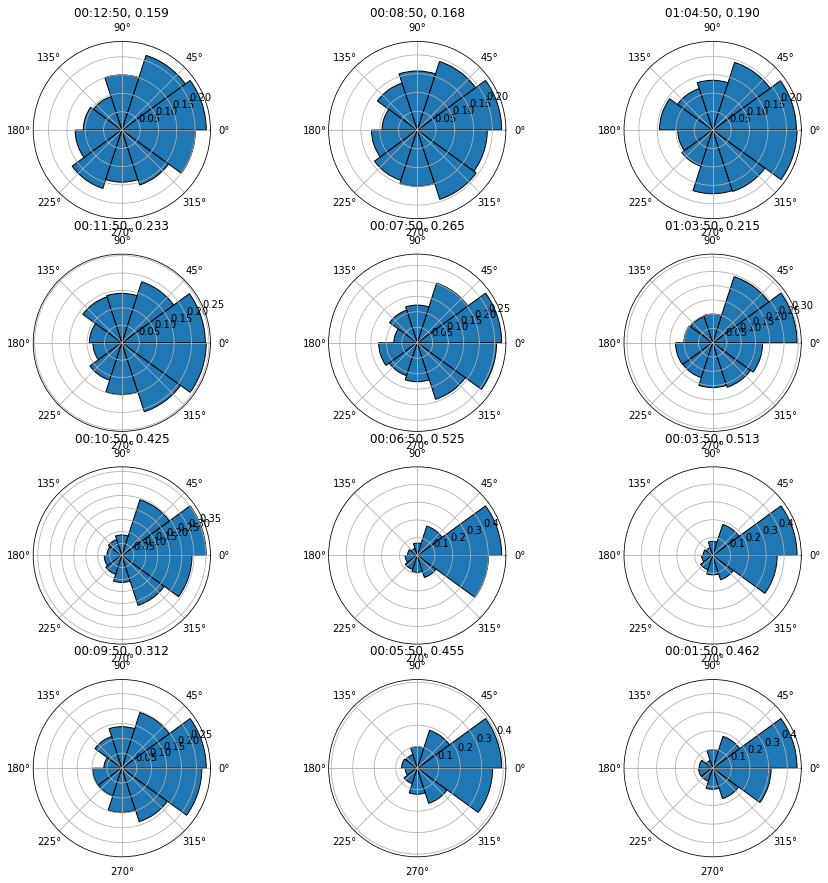

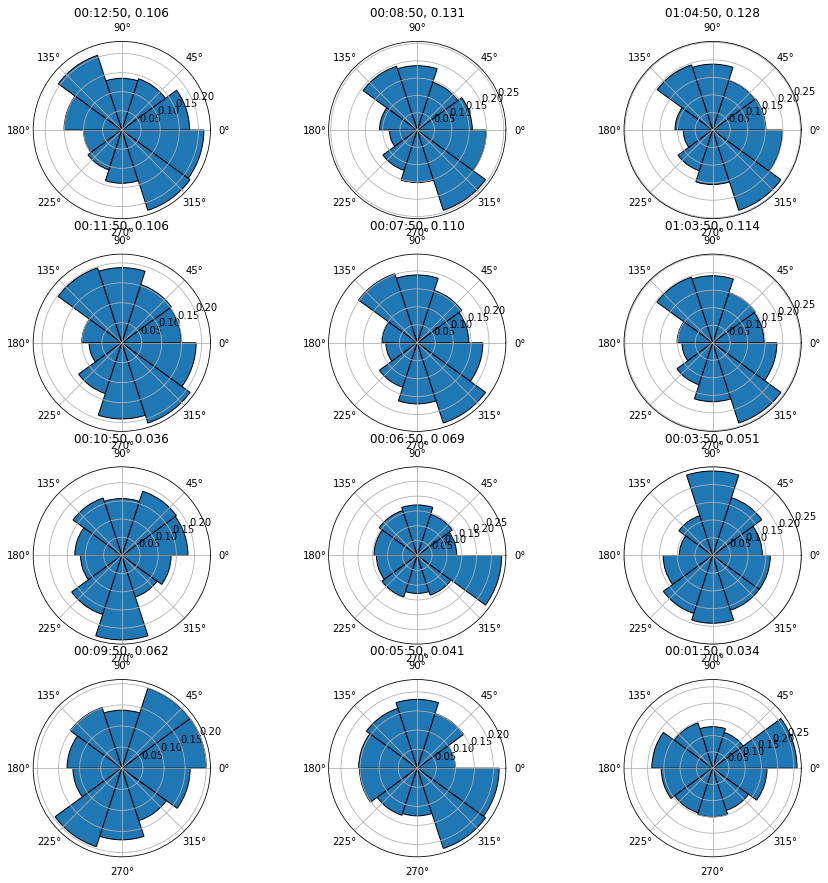

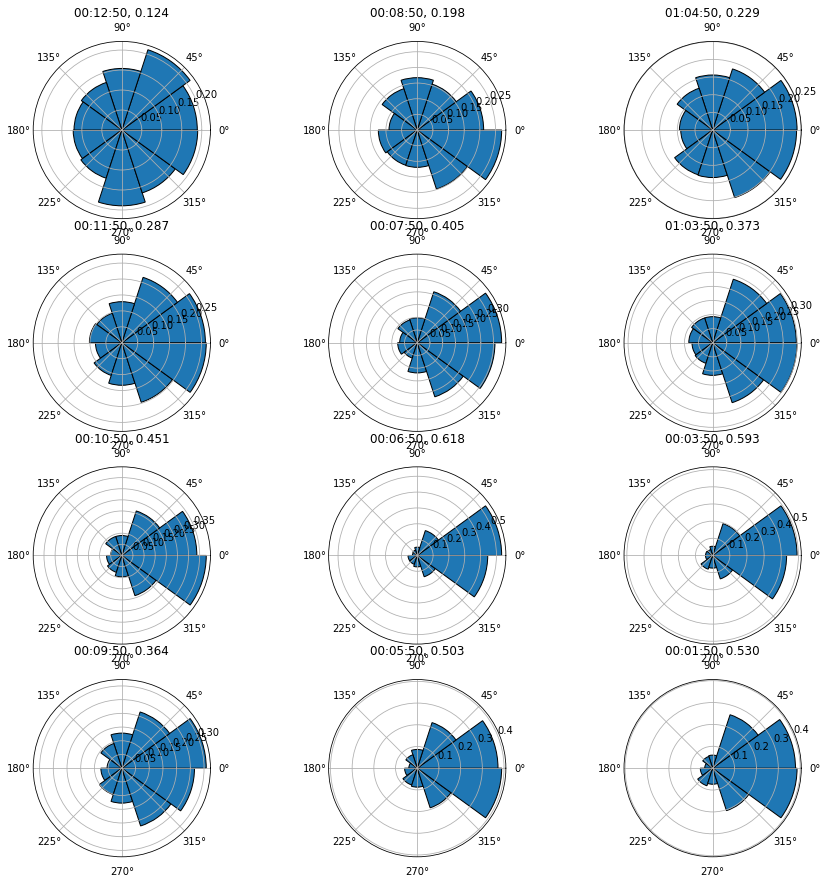

In [22]:
# No tACS

flicker_stimulus_phase = raw_photodiode_no_tacs.copy().filter(9,11, picks=photodiode_channel)._data[0,start_marker_index_no_tacs:end_marker_index_no_tacs]
flicker_stimulus_phase = np.angle(hilbert(flicker_stimulus_phase), deg=False)

raw_fil_10_no_tacs_cut = raw_fil_10_no_tacs._data.squeeze()[:, start_marker_index_no_tacs:end_marker_index_no_tacs]

plt.figure(figsize=(15,15))
## for each channel
for i in range(num_primary_channels): 

    opm_angle = np.angle(hilbert(raw_fil_10_no_tacs_cut[i]), deg=False)
    
    data = wrap(flicker_stimulus_phase-opm_angle)

    plt.subplot(4,3,i+1, polar=True)
    # ax.get_yaxis().set_visible(False)
    plv, detrend_data = circ_detrend(data)

    plt.hist(detrend_data,density=True,edgecolor='black')
    plt.title('%s, %.3f' % (raw_no_tacs.ch_names[i], np.abs(plv)))


# tACS

flicker_stimulus_phase = raw_photodiode_tacs.copy().filter(9,11, picks=photodiode_channel)._data[0,start_marker_index_tacs:end_marker_index_tacs]
flicker_stimulus_phase = np.angle(hilbert(flicker_stimulus_phase), deg=False)

raw_fil_10_tacs_cut = raw_fil_10_tacs._data.squeeze()[:, start_marker_index_tacs:end_marker_index_tacs]

plt.figure(figsize=(15,15))
## for each channel
for i in range(num_primary_channels): 

    opm_angle = np.angle(hilbert(raw_fil_10_tacs_cut[i]), deg=False)
    
    data = wrap(flicker_stimulus_phase-opm_angle)

    plt.subplot(4,3,i+1, polar=True)
    # ax.get_yaxis().set_visible(False)
    plv, detrend_data = circ_detrend(data)

    plt.hist(detrend_data,density=True,edgecolor='black')
    plt.title('%s, %.3f' % (raw_tacs.ch_names[i], np.abs(plv)))

# tACS - SASS

raw_fil_10_tacs_cut = raw_sass.copy().filter(9,10)._data.squeeze()[:, start_marker_index_tacs:end_marker_index_tacs]

plt.figure(figsize=(15,15))
## for each channel
for i in range(num_primary_channels): 

    opm_angle = np.angle(hilbert(raw_fil_10_tacs_cut[i]), deg=False)
    
    data = wrap(flicker_stimulus_phase-opm_angle)

    plt.subplot(4,3,i+1, polar=True)
    # ax.get_yaxis().set_visible(False)
    plv, detrend_data = circ_detrend(data)

    plt.hist(detrend_data,density=True,edgecolor='black')
    plt.title('%s, %.3f' % (raw_tacs.ch_names[i], np.abs(plv)))
